<a href="https://colab.research.google.com/github/viktoriya-bel/Tensorflow-labs/blob/main/ConvolutionsPullings_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Повышение точности компьютерного зрения с помощью сверток

В предыдущих уроках вы видели, как распознавать вещи, используя глубокую нейронную сеть (DNN), содержащую три слоя - входной слой (в форме данных), выходной слой (в форме желаемого результата) и скрытый слой. Вы экспериментировали, как повлияет изменение размера скрытого слоя, количества эпох обучения и т. д. на конечную точность.

Для удобства здесь опять выложен весь тот код. Запустите его и запишите полученную в конце точность теста.


In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images / 255.0
test_images=test_images / 255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)

test_loss = model.evaluate(test_images, test_labels)

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 13s 4ms/step - loss: 0.5005 - accuracy: 0.8232
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3728 - accuracy: 0.8647
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3361 - accuracy: 0.8768
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3104 - accuracy: 0.8866
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3659 - accuracy: 0.8694


Ваша точность, вероятно, будет около 89% при обучении и 87% на тестировании. Как ее увеличить? Один из способов - использовать то, что называется Convolutions. 
Если вы когда-либо выполняли обработку изображений с использованием фильтра (например, https://en.wikipedia.org/wiki/Kernel_(image_processing)), то свертки будут выглядеть очень знакомо.

Запустите приведенный ниже код - это та же нейронная сеть, что и раньше, но на этот раз сначала добавляются сверточные слои. Это займет больше времени, но посмотрите на точность:

In [ ]:
import tensorflow as tf
print(tf.__version__)
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64,  (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(training_images, training_labels, epochs=5)
test_loss = model.evaluate(test_images, test_labels)


2.11.0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)       

Вероятно, он вырос до 93% по данным обучения и до 91% по данным проверки.
Это шаг в правильном направлении!
Попробуйте запустить его для большего количества эпох - скажем, около 20, и изучите результаты. Но хотя результаты могут показаться действительно хорошими, результаты валидации могут на самом деле снизиться из-за того, что называется «переобучением», которое будет обсуждаться позже.
(В двух словах, «переобучение» происходит, когда сеть действительно хорошо изучает данные из обучающего набора, но слишком специализируется на этих конкретных данных, и в результате становится менее эффективной на других данных. Например, если всю жизнь Вы видели только красные туфли, то когда вы видите красную обувь, вы очень хорошо ее опознаете, но синие замшевые туфли могут сбить вас с толку.)

Затем снова посмотрите на код и, шаг за шагом, посмотрите, как были построены свертки:

Шаг 1 - собрать данные. Вы заметите, что здесь есть небольшое изменение: данные обучения необходимо переформировать. Это связано с тем, что первая свертка ожидает единственный тензор, содержащий сразу все примеры обучения, поэтому вместо 60000 элементов 28x28x1 в списке мы имеем один четырехмерный список размером 60000x28x28x1, и то же самое для тестовых изображений. Если вы этого не сделаете, вы получите ошибку при обучении, поскольку Convolutions не поймут другую форму.


```
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
```



Далее следует определить вашу модель. Теперь вместо входного слоя вверху вы добавите Convolution. Параметры:

1. Количество сверток, которые вы хотите сгенерировать. Чисто произвольно, но хорошо начать с чего-то порядка 32
2. Размер свертки, в данном случае 3х3
3. Используемая функция активации - здесь мы будем использовать функцию relu, которая, как вы помните, возвращает x при x > 0, в противном случае возвращает 0
4. Форма входных данных на первом слое.

За Convolution следует слой MaxPooling, который предназначен для сжатия изображений, с сохранением признаков, которые были выделены в результате сверток. Задав (2,2) для MaxPooling, вы получите уменьшение размера изображения в четыре раза. Не вдаваясь в подробности, идея состоит в том, что пуллинг создает 2х2 массив пикселей и выбирает из них один с самым большим значением, превращая 4 пикселя в 1. Он повторяет это по всему изображению, уменьшая изображение в 4 раза.

Вы можете вызвать model.summary(), чтобы увидеть размер и форму сети, и вы заметите, как после каждого слоя MaxPooling уменьшается размер изображения.

```
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
```



Добавляем еще одну свертку



```
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2)
```



Теперь надо "распластать" результат. После этого вы будете иметь такую же структуру данных, как и в версии нейронной сети без сверток, которую мы делали в прошлый раз.

```
  tf.keras.layers.Flatten(),
```



Те же 128 нейронов в полносвязном слое и 10 нейронов в слое выхода, что и в примере до свертки:


```
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
```



Теперь скомпилируйте модель, вызовите метод fit для обучения и оцените loss и accuracy на тестовом наборе.

```
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)
```




#Визуализация сверток и пуллинга

Этот код покажет нам свертки графически. print(test_labels [; 100]) покажет нам первые 100 распознанных меток в тестовом наборе, и вы можете видеть, что нулевая 0, 23-я и 28-я имеют одинаковое значение (9). Это все ботинки. Давайте посмотрим на результат запуска свертки для каждого, и вы начнете видеть как появляются общие черты между ними. Теперь, когда DNN обучается на этих данных, она работает с гораздо меньшими затратами и, возможно, обнаруживает общие признаки между ботинками на основе этой комбинации свертки/пуллинга.

In [ ]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


1/1 [==============================] - 0s 18ms/step


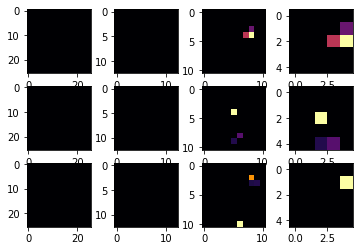

In [ ]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

##УПРАЖНЕНИЯ

1. Попробуйте изменить свертки. Измените 32 на 16 или 64. Как это повлияет на точность и/или время обучения?

2. Удалите окончательную свертку. Как это повлияет на точность или время обучения?

3. Как насчет добавления большего количества сверток? Как вы думаете, какое влияние это окажет? Экспериментируйте с этим.

4. Удалите все свертки, кроме первой. Как вы думаете, какое влияние это окажет? Экспериментируйте с этим.

5. В предыдущем уроке вы реализовали функцию обратного вызова, чтобы проверить функцию потерь и отменить тренировку, когда она достигнет определенной суммы. Посмотрите, сможете ли вы реализовать это здесь.


In [ ]:
import tensorflow as tf
print(tf.__version__)
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=10)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

2.11.0
11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.1440 - accuracy: 0.9576
Epoch 2/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0477 - accuracy: 0.9859
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0299 - accuracy: 0.9908
Epoch 4/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0193 - accuracy: 0.9937
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0123 - accuracy: 0.9959
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0098 - accuracy: 0.9966
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0070 - accuracy: 0.9976
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0057 - accuracy: 0.9981
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0053 - accuracy: 0.9983
Epoch 10/1